In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# General imports
import numpy as np
import pandas as pd
import os, warnings, datetime, math

from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss


from sklearn.metrics import roc_curve
# from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier

warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

from copy import deepcopy
from IPython.display import SVG

from keras.utils.vis_utils import model_to_dot

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 51 kB/s 


# Minification

In [ ]:
########################### Helpers
#################################################################################
## -------------------
## Memory Reducer
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
## -------------------

In [ ]:
########################### DATA LOAD
#################################################################################
print('Load Data')
train_df = pd.read_csv('../input/ieeefrauddetectionorigindataset/train_transaction.csv')
test_df = pd.read_csv('../input/ieeefrauddetectionorigindataset/test_transaction.csv')
test_df['isFraud'] = 0

train_identity = pd.read_csv('../input/ieeefrauddetectionorigindataset/train_identity.csv')
test_identity = pd.read_csv('../input/ieeefrauddetectionorigindataset/test_identity.csv')

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
# Rename the id col in 
new_cols = [x.replace('_', '-') for x in train_identity.columns if 'id' in x]
new_cols
train_identity.rename(columns=dict(zip([x for x in train_identity.columns if 'id' in x], new_cols)), inplace=True)

In [ ]:
########################### Base check
#################################################################################

for df in [train_df, test_df, train_identity, test_identity]:
    original = df.copy()
    df = reduce_mem_usage(df)

    for col in list(df):
        if df[col].dtype!='O':
            if (df[col]-original[col]).sum()!=0:
                df[col] = original[col]
                print('Bad transformation', col)

In [ ]:
# Watch the overview of dataset
for df in [train_identity]:
    for col, values in df.iteritems():
        num_uniques = values.nunique()
        print ('{name}: {num_unique}'.format(name=col, num_unique=num_uniques))
        print (values.unique())
        print ('\n')
    print('-'*50)

In [ ]:
########################### card4, card6, ProductCD
#################################################################################
# Converting Strings to ints(or floats if nan in column) using frequency encoding
# We will be able to use these columns as category or as numerical feature

for col in ['card4', 'card6', 'ProductCD']:
    print('Encoding', col)
    temp_df = pd.concat([train_df[[col]], test_df[[col]]])
    col_encoded = temp_df[col].value_counts().to_dict()   
    train_df[col] = train_df[col].map(col_encoded)
    test_df[col]  = test_df[col].map(col_encoded)
    print(col_encoded)

In [ ]:
########################### M columns
#################################################################################
# Converting Strings to ints(or floats if nan in column)

for col in ['M1','M2','M3','M5','M6','M7','M8','M9']:
    train_df[col] = train_df[col].map({'T':1, 'F':0})
    test_df[col]  = test_df[col].map({'T':1, 'F':0})

for col in ['M4']:
    print('Encoding', col)
    temp_df = pd.concat([train_df[[col]], test_df[[col]]])
    col_encoded = temp_df[col].value_counts().to_dict()   
    train_df[col] = train_df[col].map(col_encoded)
    test_df[col]  = test_df[col].map(col_encoded)
    print(col_encoded)

In [ ]:
########################### Identity columns
#################################################################################

# id-30: OS type
# id-31: browser
# id-33: monitor's size
# id-34: (match_status:1)



def minify_identity_df(df):

    df['id-12'] = df['id-12'].map({'Found':1, 'NotFound':0})
    df['id-15'] = df['id-15'].map({'New':2, 'Found':1, 'Unknown':0})
    df['id-16'] = df['id-16'].map({'Found':1, 'NotFound':0})

    df['id-23'] = df['id-23'].map({'IP_PROXY:TRANSPARENT':3, 'IP_PROXY:ANONYMOUS':2, 'IP_PROXY:HIDDEN':1})

    df['id-27'] = df['id-27'].map({'Found':1, 'NotFound':0})
    df['id-28'] = df['id-28'].map({'New':2, 'Found':1})

    df['id-29'] = df['id-29'].map({'Found':1, 'NotFound':0})

    df['id-35'] = df['id-35'].map({'T':1, 'F':0})
    df['id-36'] = df['id-36'].map({'T':1, 'F':0})
    df['id-37'] = df['id-37'].map({'T':1, 'F':0})
    df['id-38'] = df['id-38'].map({'T':1, 'F':0})

    df['id-34'] = df['id-34'].fillna(':0')
    df['id-34'] = df['id-34'].apply(lambda x: x.split(':')[1]).astype(np.int8)
    df['id-34'] = np.where(df['id-34']==0, np.nan, df['id-34'])
    
    df['id-33'] = df['id-33'].fillna('0x0')
    df['id-33-0'] = df['id-33'].apply(lambda x: x.split('x')[0]).astype(int)
    df['id-33-1'] = df['id-33'].apply(lambda x: x.split('x')[1]).astype(int)
    df['id-33'] = np.where(df['id-33']=='0x0', np.nan, df['id-33'])

    df['DeviceType'].map({'desktop':1, 'mobile':0})
    return df

In [ ]:
train_identity = minify_identity_df(train_identity)
test_identity = minify_identity_df(test_identity)

In [ ]:
# Encode the id-33 which is the col that describes the monitor's size

for col in ['id-33']:
    train_identity[col] = train_identity[col].fillna('unseen_before_label')
    test_identity[col]  = test_identity[col].fillna('unseen_before_label')
    
    le = LabelEncoder()
    le.fit(list(train_identity[col])+list(test_identity[col]))
    train_identity[col] = le.transform(train_identity[col])
    test_identity[col]  = le.transform(test_identity[col])

In [ ]:
########################### Final check
#################################################################################

for df in [train_df, test_df, train_identity, test_identity]:
    original = df.copy()
    df = reduce_mem_usage(df)

    for col in list(df):
        if df[col].dtype!='O':
            if (df[col]-original[col]).sum()!=0:
                df[col] = original[col]
                print('Bad transformation', col)

In [ ]:
########################### Full minification for fast tests
#################################################################################
for df in [train_df, test_df, train_identity, test_identity]:
    df = reduce_mem_usage(df)

In [ ]:
########################### Export
#################################################################################

train_df.to_pickle('train_transaction.pkl')
test_df.to_pickle('test_transaction.pkl')

train_identity.to_pickle('train_identity.pkl')
test_identity.to_pickle('test_identity.pkl')

# FE with EDA

# Detecting clients

## Finding cardID

In [ ]:
train = train_transaction.merge(train_id, how='left', left_on='TransactionID',right_on='TransactionID')

In [ ]:
import math, itertools
def keygroup(df, cols, name_new_col):
  df.loc[:, name_new_col] = ''
  for col in cols:
    df.loc[:, name_new_col] += df.loc[:, col].astype(str)
  return df

def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n  

train['day'] = train['TransactionDT']/(3600*24)
train['D1minusday'] = (train['D1'] - train['day']).replace(np.nan, -9999).map(int)
colsID = ['card1','card2','card3','card4','card5','card6','D1minusday','ProductCD']
train = keygroup(train, colsID, 'cardID_D1')

# full_df = pd.concat([train, test]).reset_index(drop=True)

In [ ]:
cardGroups_df = pd.DataFrame({'cardGroup_name':temp.index, 'counts':temp.values})

In [ ]:
train['V307'] = train['V307'].fillna(0)
train['V307plus'] = train['V307'] + train['TransactionAmt']

In [ ]:
# check the first value of the list
train.loc[(train.TransactionID==3030465),'V307'].values[0] == train.loc[(train.TransactionID==3026025),'V307plus'].values[0]

In [ ]:
# After many iterations, trial and errors, I ended-up with the following function, grouping based on:
train['V307trunc'] = train['V307'].apply(lambda x: truncate(x, 3))
train['V307round'] = train['V307'].apply(lambda x: round(x, 3))
train['V307plusround'] = train['V307plus'].apply(lambda x: round(x, 4))
train['V307plusroundtrunc'] = train['V307plusround'].apply(lambda x: truncate(x, 3))
train['V307plusround'] = train['V307plus'].apply(lambda x: round(x, 3))
train['V307trunc2'] = train['V307'].apply(lambda x: truncate(x, 2))
train['V307plustrunc2'] = train['V307plus'].apply(lambda x: truncate(x, 2))
train['TransactionAmttrunq'] = train['TransactionAmt'].apply(lambda x: round(x, 3))
train['V307plusround2'] = train['V307plus'].apply(lambda x: round(x, 2))

In [ ]:
def merge(list1, list2): 
  merged_list = [[p1, p2] for idx1, p1 in enumerate(list1)  
  for idx2, p2 in enumerate(list2) if idx1 == idx2] 
  return merged_list  

In [ ]:
import networkx as nx
def find_groups(aa):
  group_list = []
    
    
  #get the couples by existstrunc
  list1 = aa['V307plustrunc2'].tolist()
  list2 = aa['V307trunc2'].tolist()
  kv = []
  res = [[list(filter(lambda z: list1[z]==x, range(len(list1)))),list(filter(lambda z: list2[z]==x, range(len(list2))))] for x in list1 if x in list2] #find the pairs
  res= [list(map(kv.append,map(list,(itertools.product(*sublist))))) for sublist in res] #drop duplicates from list of list
  res = list(map(list, set(map(lambda i: tuple(i), kv)))) #create list of couple indexes
  list1 = aa.iloc[[i[0] for i in res]]['TransactionID'].tolist()
  list2 = aa.iloc[[i[1] for i in res]]['TransactionID'].tolist()
  liste_existstrun = merge(list1, list2)

  #get the couples by existsroundtrunc
  list1 = aa['V307plusround2'].tolist()
  list2 = aa['V307trunc2'].tolist()
  kv = []
  res = [[list(filter(lambda z: list1[z]==x, range(len(list1)))),list(filter(lambda z: list2[z]==x, range(len(list2))))] for x in list1 if x in list2] #find the pairs
  res= [list(map(kv.append,map(list,(itertools.product(*sublist))))) for sublist in res] #drop duplicates from list of list
  res = list(map(list, set(map(lambda i: tuple(i), kv)))) #create list of couple indexes
  list1 = aa.iloc[[i[0] for i in res]]['TransactionID'].tolist()
  list2 = aa.iloc[[i[1] for i in res]]['TransactionID'].tolist()
  liste_existstrun2 = merge(list1, list2)

  #get the couples by existsroundtrunc
  list1 = aa['V307plusroundtrunc'].tolist()
  list2 = aa['V307round'].tolist()
  kv = []
  res = [[list(filter(lambda z: list1[z]==x, range(len(list1)))),list(filter(lambda z: list2[z]==x, range(len(list2))))] for x in list1 if x in list2] #find the pairs
  res= [list(map(kv.append,map(list,(itertools.product(*sublist))))) for sublist in res] #drop duplicates from list of list
  res = list(map(list, set(map(lambda i: tuple(i), kv)))) #create list of couple indexes
  list1 = aa.iloc[[i[0] for i in res]]['TransactionID'].tolist()
  list2 = aa.iloc[[i[1] for i in res]]['TransactionID'].tolist()
  liste_existsroundtrunc = merge(list1, list2)

  #get the couples by existsroundtrunc
  list1 = aa['V307plusround'].tolist()
  list2 = aa['V307round'].tolist()
  kv = []
  res = [[list(filter(lambda z: list1[z]==x, range(len(list1)))),list(filter(lambda z: list2[z]==x, range(len(list2))))] for x in list1 if x in list2] #find the pairs
  res= [list(map(kv.append,map(list,(itertools.product(*sublist))))) for sublist in res] #drop duplicates from list of list
  res = list(map(list, set(map(lambda i: tuple(i), kv)))) #create list of couple indexes
  list1 = aa.iloc[[i[0] for i in res]]['TransactionID'].tolist()
  list2 = aa.iloc[[i[1] for i in res]]['TransactionID'].tolist()
  liste_existsroundround = merge(list1, list2)

  #get the couples by existsamount
  list1 = aa['TransactionAmttrunq'].tolist()
  list2 = aa['V307round'].tolist()
  kv = []
  res = [[list(filter(lambda z: list1[z]==x, range(len(list1)))),list(filter(lambda z: list2[z]==x, range(len(list2))))] for x in list1 if x in list2] #find the pairs
  res= [list(map(kv.append,map(list,(itertools.product(*sublist))))) for sublist in res] #drop duplicates from list of list
  res = list(map(list, set(map(lambda i: tuple(i), kv)))) #create list of couple indexes
  list1 = aa.iloc[[i[0] for i in res]]['TransactionID'].tolist()
  list2 = aa.iloc[[i[1] for i in res]]['TransactionID'].tolist()
  liste_existsamount = merge(list1, list2)

  #get by exact same amount
  a=[]
  liste_sameamount = aa.groupby('TransactionAmt')['TransactionID'].apply(list).tolist()
  res = [list(map(a.append, map(list,zip(i, i[1:] + i[:1])))) for i in liste_sameamount]

  group_list.extend(liste_existstrun)
  group_list.extend(liste_existstrun2)
  group_list.extend(liste_existsroundtrunc)
  group_list.extend(liste_existsamount)
  group_list.extend(liste_existsroundround)

  group_list.extend(a)

  L = group_list
  G = nx.Graph()
  G.add_nodes_from(sum(L, []))
  q = [[(s[i],s[i+1]) for i in range(len(s)-1)] for s in L]
  for i in q:
    G.add_edges_from(i)
  group_list = [list(i) for i in nx.connected_components(G)]
  return group_list

In [ ]:
# Card group valid, which <= 180 transactions
# cardGroups_valid_df = cardGroups_df[cardGroups_df['counts']<=180]
cardGroups_invalid_df = cardGroups_df[cardGroups_df['counts']>180]

# Dictionary of cardID
cardID_invalid_dict = {}

for name in list(cardGroups_invalid_df.cardGroup_name):
  card_group = train[train.cardID_D1==name]
  x = find_groups(card_group)
  cardID_invalid_dict[name] = x

In [ ]:
# The function is used to assign the cardID for each transactionID

def assignCardID(df):
  for i in range(len(df)):
    df.loc[i, 'TransactionID'] = json.loads(df.loc[i, 'TransactionID'])
  cardID_dict = {}
  cardID_dict["TransactionID"] = []
  cardID_dict["CardID"] = []
  for i in range(len(df)):
    t = df.loc[i, "TransactionID"]
    for j in range(len(t)):
      for k in range(len(t[j])):
        cardID_dict["TransactionID"].append(t[j][k])
        cardID_dict["CardID"].append("group" + str(i) + "_" + str(j))
  
  return pd.DataFrame(cardID_dict)

## Finding userID

In [ ]:
import pandas as pd
import numpy as np

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
train_transaction = pd.read_pickle('Data/isi-minification/train_transaction.pkl')        
train_identity = pd.read_pickle('Data/isi-minification/train_identity.pkl')
# test_transaction = pd.read_pickle('Data/isi-minification/test_transaction.pkl')        
# test_identity = pd.read_pickle('Data/isi-minification/test_identity.pkl')

train_transaction = train_transaction[['TransactionID','TransactionDT','TransactionAmt','ProductCD']]
train_identity = train_identity[['TransactionID','id-19','id-20','id-31','DeviceInfo']]
# test_transaction = test_transaction[['TransactionID','TransactionDT','TransactionAmt','ProductCD']]
# test_identity = test_identity[['TransactionID','id-19','id-20','id-31','DeviceInfo']]

# train_transaction = train_transaction.merge(train_identity, how='left', left_on='TransactionID', right_on='TransactionID')
test_transaction = test_transaction.merge(test_identity, how='left', left_on='TransactionID', right_on='TransactionID')

total = test_transaction.copy()
# del train_transaction
del test_transaction

In [ ]:
import itertools
import math
import networkx as nx

def create_key(df, cols, name_new_col):
  '''
  df: pandas dataframe
  cols: list of cols composing the key
  name_new_col: name given to the new column
  '''
  df.loc[:, name_new_col] = ''
  for col in cols:
    df.loc[:, name_new_col] = df.loc[:, name_new_col] + df.loc[:, col].astype(str)
  return df

def truncate(f, n):
  return math.floor(f*10**n)/10**n

def merge(list1, list2):
  merged_list = [[p1, p2] for idx1, p1 in enumerate(list1) for idx2, p2 in enumerate(list2) if idx1 == idx2]
  return merged_list

def find_groups(df, groupingCriteria):
  a = []
  liste_sameAmount = df.groupby(groupingCriteria)['TransactionID'].apply(list).tolist()
  res = [list(map(a.append, map(list,zip(i, i[1:] + i[:1])))) for i in liste_sameAmount]
  return a



In [ ]:
groups = pd.read_csv('train_valid_card.csv')
groups = groups.set_index('TransactionID')
dictgroups = groups['CardID'].to_dict()
total['cardID'] = total['TransactionID'].map(dictgroups)

In [ ]:
#  filter the valid card
total = total[~total['cardID'].isna()]

In [ ]:
total['day'] = total['TransactionDT']/(3600*24)
total['daytrunc'] = total['day'].apply(lambda x: truncate(x, 1))
total['dayround'] = total['day'].apply(lambda x: round(x, 1))
total['TransactionAmtround'] = total['TransactionAmt'].apply(lambda x: round(x, 3))

### Create the first key ['TransactionAmtround', 'id-19', 'id-20']

In [ ]:
cols_1 = ['TransactionID', 'TransactionAmt', 'TransactionAmtround', 'id-19', 'id-20', 'daytrunc', 'dayround', 'day']
total1 = total[cols_1].copy()
total1 = create_key(total1, ['TransactionAmtround', 'id-19', 'id-20'], '1stGroup_criteria')

In [ ]:
import gc
timeframe = total1.dayround.unique().tolist()
group_list_criteria1 = []

for frame in timeframe:
  if frame%50 == 0:
    print('day', frame)
    gc.collect()

  subset = total1[total1['dayround']==frame].copy()
  if len(subset)==1:
    group_list_criteria1.append(subset['TransactionID'].tolist())
  else:
    a = find_groups(subset, '1stGroup_criteria')
    group_list_criteria1.extend(a)

In [ ]:
print(len(group_list_criteria1))
group_list_criteria1 = [list(tupl) for tupl in {tuple(item) for item in group_list_criteria1}]
print(len(group_list_criteria1))

In [ ]:
L = group_list_criteria1
G = nx.Graph()

G.add_nodes_from(sum(L, []))
q = [[(s[i], s[i+1]) for i in range(len(s)-1)] for s in L]
for i in q:
  G.add_edges_from(i)

group_list = [list(i) for i in nx.connected_components(G)]
myDict = {}

for i in range(0, len(group_list)):
  for element in group_list[i]:
    name = 'group' + str(i)
    myDict[element] = name



In [ ]:
import csv

with open ('train_groups_Amt-id19-20.csv', 'w') as output:
    writer = csv.writer(output)
    writer.writerow(['TransactionID','groups_Amt-id19-20'])
    for k, v in myDict.items():
        writer.writerow([k, v])

### Create the second key [['id_19','id_20','id_31','DeviceInfo']]

In [ ]:
total1 = total[['TransactionID','id-19','id-20','id-31','DeviceInfo','daytrunc','dayround','day']].copy()
total1 = create_key(total1, ['id-19','id-20','id-31','DeviceInfo'],'2ndGroup_criteria')
total1 = total1[(total1['id-20'].isna()==False) & (total1['id-19'].isna()==False) & (total1['id-31'].isna()==False)]
# this key is too indulgent if we don't get rid of missing id_19 and id_20 as many are missing, but try your experiments to find the best combination

In [ ]:
import gc
timeframe = total1.dayround.unique().tolist()
group_list_criteria1 = []

for frame in timeframe:
    if frame%50==0:
        print('day',frame)
        gc.collect()
    
    subset = total1[total1['dayround']==frame].copy()
    if len(subset)==1:
        group_list_criteria1.append(subset['TransactionID'].tolist())
    else:
        group_list_criteria1.extend(find_groups(subset, '2ndGroup_criteria'))
    
## Second on Truncated data
timeframe = total1.daytrunc.unique().tolist()

for frame in timeframe:
    if frame%50==0:
        print('day',frame)
        gc.collect()
    
    subset = total1[total1['daytrunc']==frame].copy()
    if len(subset)==1:
        group_list_criteria1.append(subset['TransactionID'].tolist())
    else:
        group_list_criteria1.extend(find_groups(subset, '2ndGroup_criteria')) 

In [ ]:
print(len(group_list_criteria1))
group_list_C_criteria1 = [list(tupl) for tupl in {tuple(item) for item in group_list_criteria1 }]
print(len(group_list_criteria1)) 

In [ ]:
L = group_list_C_criteria1
G = nx.Graph()

G.add_nodes_from(sum(L, []))
q = [[(s[i],s[i+1]) for i in range(len(s)-1)] for s in L]
for i in q:
    G.add_edges_from(i)

group_list = [list(i) for i in nx.connected_components(G)]

# groupsCid192031Device = pd.DataFrame.from_dict(myDict, orient='index').reset_index()
# groupsCid192031Device.columns=['TransactionID','groupsCid192031Device']

In [ ]:
with open ('train_groups_id19-20-31-Device.csv', 'w') as output:
    writer = csv.writer(output)
    writer.writerow(['TransactionID','groups_id19-20-31-Device'])
    for k, v in myDict.items():
        writer.writerow([k, v])

### Key3: CardID

In [ ]:
total1 = total[['TransactionID','day','cardID']].copy()

group1 = pd.read_csv('test_groups_Amt-id19-20.csv')
group2 = pd.read_csv('test_groups_id19-20-31-Device.csv')


In [ ]:
total1 = total1.merge(group1, how='left',left_on='TransactionID',right_on='TransactionID')
total1 = total1.merge(group2, how='left',left_on='TransactionID',right_on='TransactionID')

In [ ]:
#imputation
total1['imputecol'] = [i for i in range(0,len(total1))]
total1.loc[total1['groups_id19-20-31-Device'].isna(), 'groups_id19-20-31-Device'] = total1.loc[total1['groups_id19-20-31-Device'].isna(), 'imputecol']

In [ ]:
groups_final = []
groups_final.extend(find_groups(total1, 'cardID'))
print('group1done')

groups_final.extend(find_groups(total1, 'groups_Amt-id19-20'))
print('group2done')

groups_final.extend(find_groups(total1, 'groups_id19-20-31-Device'))
print('group3done')

print(len(groups_final))
groups_final = [list(tupl) for tupl in {tuple(item) for item in groups_final }]
print(len(groups_final))

In [ ]:
L = groups_final
G = nx.Graph()

G.add_nodes_from(sum(L, []))
q = [[(s[i],s[i+1]) for i in range(len(s)-1)] for s in L]
for i in q:
    G.add_edges_from(i)

group_list = [list(i) for i in nx.connected_components(G)]

myDict = {}

for i in range(0,len(group_list)):
    for element in group_list[i]:
        name='group'+str(i)
        myDict[element] = name
    
groupsUser = pd.DataFrame.from_dict(myDict, orient='index').reset_index()
groupsUser.columns=['TransactionID','groupsUser']
groupsUser.to_csv('groupsUser_train.csv',index=False)

In [ ]:
train_transaction = pd.read_csv('Data/Original_data/train_transaction.csv')        
train_identity = pd.read_csv('Data/Original_data/train_identity.csv')

train_transaction = train_transaction[['TransactionID','TransactionDT','TransactionAmt','ProductCD']]
train_identity = train_identity[['TransactionID','id-19','id-20','id-31','DeviceInfo']]

total = train_transaction.merge(train_identity, how='left', left_on='TransactionID', right_on='TransactionID')

# total = total[total.ProductCD=='C']
del train_transaction

In [ ]:
#cardID
groups = pd.read_csv('train_valid_card.csv')
groups = groups.set_index('TransactionID')
dictgroups = groups['CardID'].to_dict()
total['cardID'] = total['TransactionID'].map(dictgroups)

#New User group
total = total.merge(groupsUser, how='left',left_on='TransactionID',right_on='TransactionID')

In [ ]:
total['CardIDcount'] = total['cardID'].map(total.cardID.value_counts())
total['CardID_fraud_sum'] = total['cardID'].map(total.groupby('cardID')['isFraud'].sum())

total['UserIDcount'] = total['groupsUser'].map(total.groupsUser.value_counts())
total['UserID_fraud_sum'] = total['cardID'].map(total.groupby('cardID')['isFraud'].sum())

In [ ]:
total.to_csv('checkgroups_train_v1.csv',index=False)

## Split clients

In [ ]:
groupsUser = pd.read_csv('groupsUser_train.csv', index_col='TransactionID')
transaction = pd.read_pickle('minification/train_transaction.pkl')
groupsUser = groupsUser['groupsUser'].to_dict()
transaction['groupsUser'] = transaction['TransactionID'].map(groupsUser)

# filter the transaction which does not has groupUser
transaction = transaction[~transaction['groupsUser'].isna()]
label_dict = transaction['isFraud'].to_dict()


In [ ]:
y = transaction[['isFraud']]
X = transaction[[col for col in list(transaction.columns) if col != 'isFraud']]

del transaction

In [ ]:
from sklearn.model_selection import train_test_split

# split into train test sets, random_state param controls the sample suffling
# RANDOM_STATE = 111
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=111)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
known_train = X_train[X_train['groupsUser'].isin(X_test['groupsUser'])]
unknown_train = X_train[~X_train['groupsUser'].isin(X_test['groupsUser'])]
known_test = X_test[X_test['groupsUser'].isin(X_train['groupsUser'])]
unknown_test = X_test[~X_test['groupsUser'].isin(X_train['groupsUser'])]

known_train['isFraud'] = known_train['TransactionID'].map(label_dict)
unknown_train['isFraud'] = unknown_train['TransactionID'].map(label_dict)
known_test['isFraud'] = known_test['TransactionID'].map(label_dict)
unknown_test['isFraud'] = unknown_test['TransactionID'].map(label_dict)

In [ ]:
known_train.to_csv('clients/known_train.csv')
unknown_train.to_csv('clients/unknown_train.csv')
known_test.to_csv('clients/known_test.csv')
unknown_test.to_csv('clients/unknown_test.csv')

# Model

## Neural networks

In [ ]:
train_transaction = pd.read_csv('/content/drive/Shareddrives/NCKH2021/Data/[ISI]Clients/unknown_train.csv')
test_transaction = pd.read_csv('/content/drive/Shareddrives/NCKH2021/Data/[ISI]Clients/unknown_test.csv')
train_identity = pd.read_csv('/content/drive/Shareddrives/NCKH2021/Data/Original_data/train_identity.csv')
test_identity = pd.read_csv('/content/drive/Shareddrives/NCKH2021/Data/Original_data/test_identity.csv')

In [ ]:
# merge 
train_df = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test_df = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

print("Train shape : "+str(train_df.shape))
print("Test shape  : "+str(test_df.shape))# merge 
train_df = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test_df = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

print("Train shape : "+str(train_df.shape))
print("Test shape  : "+str(test_df.shape))

Train shape : (114294, 437)
Test shape  : (46317, 437)
Train shape : (114294, 437)
Test shape  : (46317, 437)


In [ ]:
['Unnamed: 0', 'TransactionID_x', 'TransactionID_y']
train_df = train_df.drop(['Unnamed: 0', 'TransactionID_y', 'TransactionID_x', 'TransactionDT'], axis=1)
test_df = test_df.drop(['Unnamed: 0', 'TransactionID_y', 'TransactionID_x', 'TransactionDT'], axis=1)

In [ ]:
# Rename the id col in 
new_cols = [x.replace('-', '_') for x in test_df.columns if 'id' in x]
new_cols
test_df.rename(columns=dict(zip([x for x in test_df.columns if 'id' in x], new_cols)), inplace=True)

del train_transaction, train_identity, test_transaction, test_identity

In [ ]:
cols = list(train_df.columns)
cols_0_V = cols[:53] + ['isFraud']

In [ ]:
import_features = pd.read_csv('/content/drive/Shareddrives/NCKH2021/Data/Nghia/feature_importance_v1.csv')
import_features.head()

,feature,importance
0,card1,1240.64
1,card2,882.76
2,addr1,803.72
3,TransactionAmt_to_std_card1,724.76
4,TransactionAmt_to_mean_card1,508.16


### Numerical & Categorical 

In [ ]:
numerical = ["TransactionAmt", "dist1", "dist2"] + ["C" + str(i) for i in range(1, 15)] + \
            ["D" + str(i) for i in range(1, 16)]
categorical = ["ProductCD", "card1", "card2", "card3", "card4", "card5", "card6", "addr1", "addr2",
               "P_emaildomain", "R_emaildomain"]+ \
                 ["M" + str(i) for i in range(1, 10)]

In [ ]:
numerical = [col for col in numerical if col in train_df.columns]
categorical = [col for col in categorical if col in train_df.columns]

In [ ]:
def fre_encode(df, cols):
    for col in cols:
        _dict = df[col].value_counts().to_dict()
        df[col] = df[col].map(_dict)

In [ ]:
def nan2mean(df):
    for x in list(df.columns.values):
        if x in numerical:
            #print("___________________"+x)
            #print(df[x].isna().sum())
            df[x] = df[x].fillna(0)
           #print("Mean-"+str(df[x].mean()))
    return df
train_df = nan2mean(train_df)
test_df = nan2mean(test_df)

### Label encoding

In [ ]:
# Label Encoding
category_counts = {}
for f in categorical:
    train_df[f] = train_df[f].replace("nan", "other")
    train_df[f] = train_df[f].replace(np.nan, "other")
    test_df[f] = test_df[f].replace("nan", "other")
    test_df[f] = test_df[f].replace(np.nan, "other")
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[f].values) + list(test_df[f].values))
    train_df[f] = lbl.transform(list(train_df[f].values))
    test_df[f] = lbl.transform(list(test_df[f].values))
    category_counts[f] = len(list(lbl.classes_)) + 1
# train_df = train_df.reset_index()
# test_df = test_df.reset_index()

### Numerical scaling

In [ ]:
for column in numerical:
    scaler = StandardScaler()
    if train_df[column].max() > 100 and train_df[column].min() >= 0:
        train_df[column] = np.log1p(train_df[column])
        test_df[column] = np.log1p(test_df[column])
    scaler.fit(np.concatenate([train_df[column].values.reshape(-1,1), test_df[column].values.reshape(-1,1)]))
    train_df[column] = scaler.transform(train_df[column].values.reshape(-1,1))
    test_df[column] = scaler.transform(test_df[column].values.reshape(-1,1))

In [ ]:
target = 'isFraud'

In [ ]:
def get_input_features(df):
    X = {'numerical':np.array(df[numerical])}
    for cat in categorical:
        X[cat] = np.array(df[cat])
    return X

In [ ]:
#cut tr and val
tr_df, val_df = train_test_split(train_df, test_size = 0.2, random_state = 42, shuffle = False)

### Detailed

Our neural network will be fairly standard. We will use the embedding layer for categoricals and the numericals will go through feed forward dense layers.

We create our embedding layers such that we have as many rows as we had categories and the dimension of the embedding is the log1p + 1 of the number of categories. So this means that categorical variables with very high cardinality will have more dimensions but not signficantly more so the information will still be compressed down to only about 13 dimensions and the smaller number of categories will be only 2-3.

We will then pass the embeddings through a spatial dropout layer which will drop dimensions within the embedding across batches and then flatten and concatenate. Then we will concatenate this to the numerical features and apply batch norm and then add some more dense layers after.

In [ ]:
from keras.layers import Concatenate, Input, Dense, Embedding, Flatten, Dropout, BatchNormalization, SpatialDropout1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import Model
from tensorflow.keras.optimizers import Adam
import keras.backend as k
def make_model():
    k.clear_session()

    categorical_inputs = []
    for cat in categorical:
        categorical_inputs.append(Input(shape=[1], name=cat))

    categorical_embeddings = []
    for i, cat in enumerate(categorical):
        categorical_embeddings.append(
            Embedding(category_counts[cat], int(np.log1p(category_counts[cat]) + 1), name = cat + "_embed")(categorical_inputs[i]))

    categorical_logits = Concatenate(name = "categorical_conc")([Flatten()(SpatialDropout1D(.1)(cat_emb)) for cat_emb in categorical_embeddings])
#     categorical_logits = Dropout(.5)(categorical_logits)

    numerical_inputs = Input(shape=[tr_df[numerical].shape[1]], name = 'numerical')
    numerical_logits = Dropout(.1)(numerical_inputs)
  
    x = Concatenate()([
        categorical_logits, 
        numerical_logits,
    ])
#     x = categorical_logits
#     x = BatchNormalization()(x)
    x = Dense(200, activation = 'relu')(x)
    x = Dropout(.2)(x)
    x = Dense(100, activation = 'relu')(x)
    x = Dropout(.2)(x)
    out = Dense(1, activation = 'sigmoid')(x)
    

    model = Model(inputs=categorical_inputs + [numerical_inputs],outputs=out)
    loss = "binary_crossentropy"
    model.compile(optimizer=Adam(lr = 0.01), loss = loss)
    return model

In [ ]:
X_train = get_input_features(tr_df[cols_0_V])
X_valid = get_input_features(val_df[cols_0_V])
X_test = get_input_features(test_df[cols_0_V])
y_train = tr_df[target]
y_valid = val_df[target]
y_test = test_df[target]
model = make_model()
best_score = 0
patience = 0

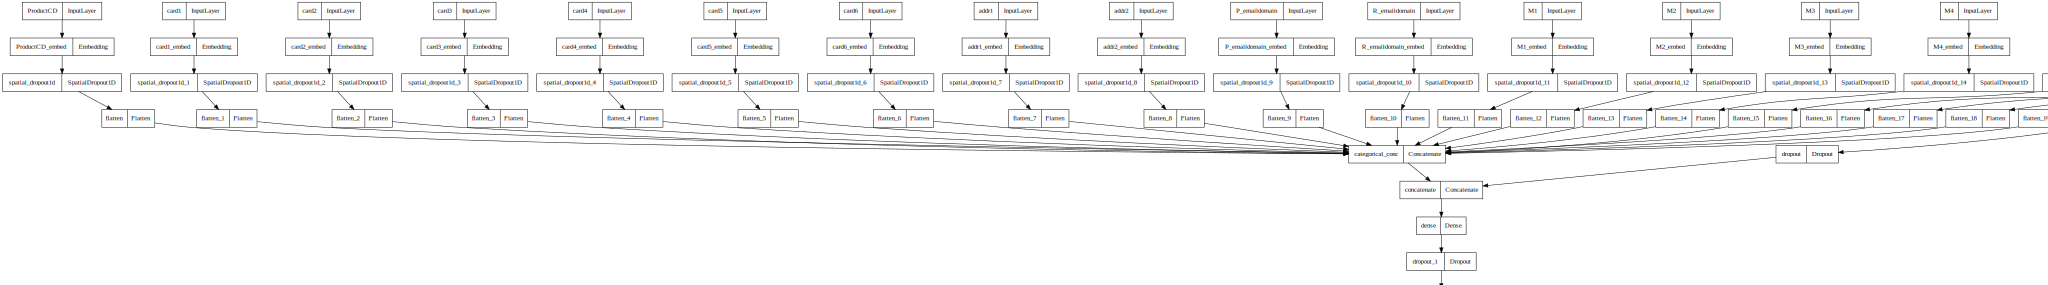

In [ ]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:

for i in range(100):
    if patience < 3:
        hist = model.fit(X_train, y_train, validation_data = (X_valid,y_valid), batch_size = 8000, epochs = 1, verbose = 1)
        valid_preds = model.predict(X_valid, batch_size = 8000, verbose = True)
        score = roc_auc_score(y_valid, valid_preds)
        print(score)
        if score > best_score:
            model.save_weights("model.h5")
            best_score = score
            patience = 0
        else:
            patience += 1
        print('-'*50)
    

3/3 [==============================] - 1s 28ms/step
0.7817274730822367
--------------------------------------------------
3/3 [==============================] - 0s 29ms/step
0.8336558217551441
--------------------------------------------------
3/3 [==============================] - 0s 36ms/step
0.8722844068321043
--------------------------------------------------
3/3 [==============================] - 0s 32ms/step
0.8771790360360117
--------------------------------------------------
3/3 [==============================] - 0s 25ms/step
0.8823027410384952
--------------------------------------------------
3/3 [==============================] - 0s 33ms/step
0.8828499512806803
--------------------------------------------------
3/3 [==============================] - 0s 39ms/step
0.8821550224326004
--------------------------------------------------
3/3 [==============================] - 0s 31ms/step
0.881781010050565
--------------------------------------------------
3/3 [====================

In [ ]:
X_test = get_input_features(test_df)
predictions = model.predict(X_test, batch_size = 2000, verbose = True)


24/24 [==============================] - 0s 12ms/step


In [ ]:
y_pred_nn = predictions.copy()
y_test_nn = y_test
X_test_nn = X_test

In [ ]:
del predictions, y_test, X_test

##Catboost

In [ ]:
cat_result = pd.read_csv('/content/drive/Shareddrives/NCKH2021/Data/Nghia/Catboost/catboost-v1.csv')
cat_result.head()

,TransactionID,isFraud,prediction
0,3457624,0,0.011541
1,3552820,0,0.002772
2,3271083,0,0.002210
3,3226689,0,0.057087
4,3268855,0,0.002003


In [ ]:
y_pred_cat = cat_result['prediction']
y_test_cat = cat_result['isFraud']

del cat_result

# Evaluation

### Accuracy metrics and probability distribution

In [ ]:
y_pred_nn_enc2

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

Accuracy: 97.60


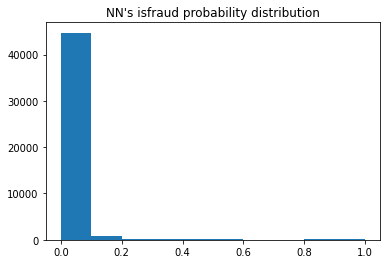

In [ ]:
plt.hist(y_pred_nn)
plt.title("NN's isfraud probability distribution")
# plt.show()

y_pred_nn_enc2 = np.where(y_pred_nn>0.2, 1, 0)
acc_nn_enc2 = accuracy_score(y_test_nn, y_pred_nn_enc2)
print('Accuracy: %.2f' % (acc_nn_enc2*100))

Accuracy: 98.64


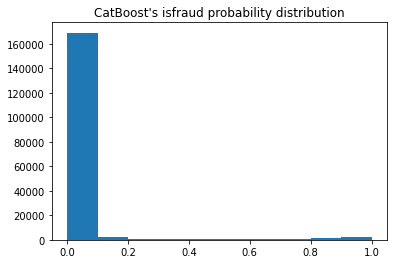

In [ ]:
plt.hist(y_pred_cat)
plt.title("CatBoost's isfraud probability distribution")
# plt.show()
y_pred_cat_enc2 = np.where(y_pred_cat>0.2, 1, 0)
acc_cat_enc2 = accuracy_score(y_test_cat, y_pred_cat_enc2)
print('Accuracy: %.2f' % (acc_cat_enc2*100))

### ROC - AUC

NN's performance at: AUC = 0.840
CatBoost's performance at: AUC = 0.974


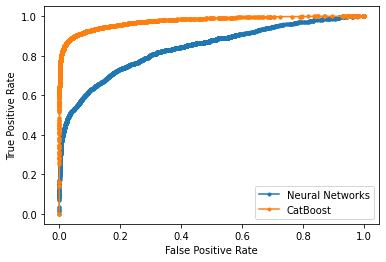

In [ ]:
# calculate scores
lr_auc_nn = roc_auc_score(y_test_nn, y_pred_nn)
lr_auc_cat = roc_auc_score(y_test_cat, y_pred_cat)

# summarize scores
print("NN's performance at: AUC = %.3f" % (lr_auc_nn))
print("CatBoost's performance at: AUC = %.3f" % (lr_auc_cat))
 
lr_fpr_nn, lr_tpr_nn, _ = roc_curve(y_test_nn, y_pred_nn)
lr_fpr_cat, lr_tpr_cat, _ = roc_curve(y_test_cat, y_pred_cat)

# plot the roc curve for the model
plt.plot(lr_fpr_nn, lr_tpr_nn, marker='.', label='Neural Networks')
plt.plot(lr_fpr_cat, lr_tpr_cat, marker='.', label='CatBoost')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

### Precision - Recall

In [ ]:
from sklearn.metrics import precision_recall_curve


def _plot_prec_rec_curve(prec, rec, thres, model):
    plt.figure(figsize = (10, 8))
    plt.plot(thres, prec[:-1], 'b--', label = 'Precision')
    plt.plot(thres, rec[:-1], 'g-', label = 'Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Probability')
    plt.title(f"{model}'s Precision vs Recall Curve")
    plt.legend()

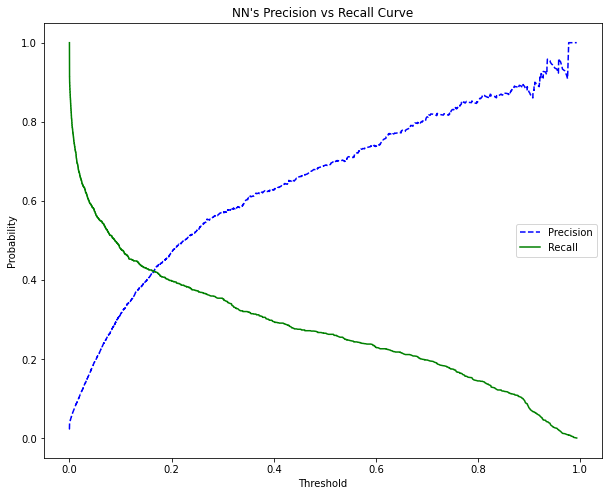

In [ ]:
prec, rec, thres = precision_recall_curve(y_test_nn, y_pred_nn)
_plot_prec_rec_curve(prec, rec, thres, "NN")

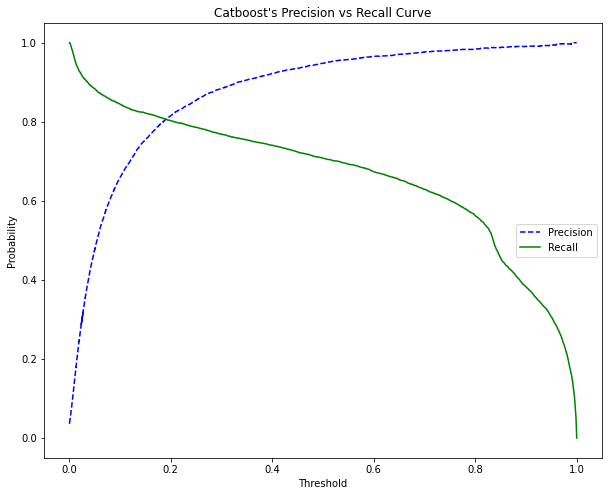

In [ ]:
prec, rec, thres = precision_recall_curve(y_test_cat, y_pred_cat)
_plot_prec_rec_curve(prec, rec, thres, "Catboost")

### Log loss

In [ ]:
log_loss_nn = log_loss(y_test_nn, y_pred_nn)
log_loss_nn

0.09025997657134768

In [ ]:
log_loss_cat = log_loss(y_test_cat, y_pred_cat)
log_loss_cat

0.04426746526017558

In [ ]:
# define an imbalanced dataset
testy = [0 for x in range(100)] + [1 for x in range(10)]
# loss for predicting different fixed probability values
predictions = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
losses = [log_loss(y_test_nn, [y for x in range(len(y_test_nn))]) for y in y_pred_nn]
# plot predictions vs loss
pyplot.plot(y_pred_nn, losses)
pyplot.show()

NameError: ignored

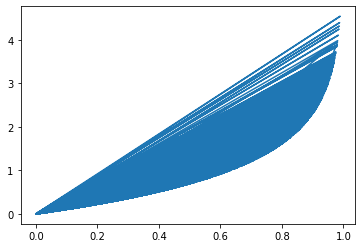

In [ ]:
plt.plot(y_pred_nn, losses_0, label='true=0')

In [ ]:
t.sort()

### Brier Loss

In [ ]:
brier_nn = log_loss(y_test_nn, y_pred_nn)
brier_nn

0.09025997657134768

# Draft 

In [ ]:
def calibration(data, train_pop, target_pop, sampled_train_pop, sampled_target_pop):

    calibrated_data = \
    ((data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)) /
    ((
        (1 - data) * (1 - target_pop / train_pop) / (1 - sampled_target_pop / sampled_train_pop)
     ) +
     (
        data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)
     )))

    return calibrated_data

In [ ]:
temp = calibration(cat_result['prediction'], 100000, 1000, 10000, 1000)

In [ ]:
temp

0         0.001060
1         0.000253
2         0.000201
3         0.005474
4         0.000182
            ...   
177157    0.000238
177158    0.000509
177159    0.001308
177160    0.000161
177161    0.000410
Name: prediction, Length: 177162, dtype: float64

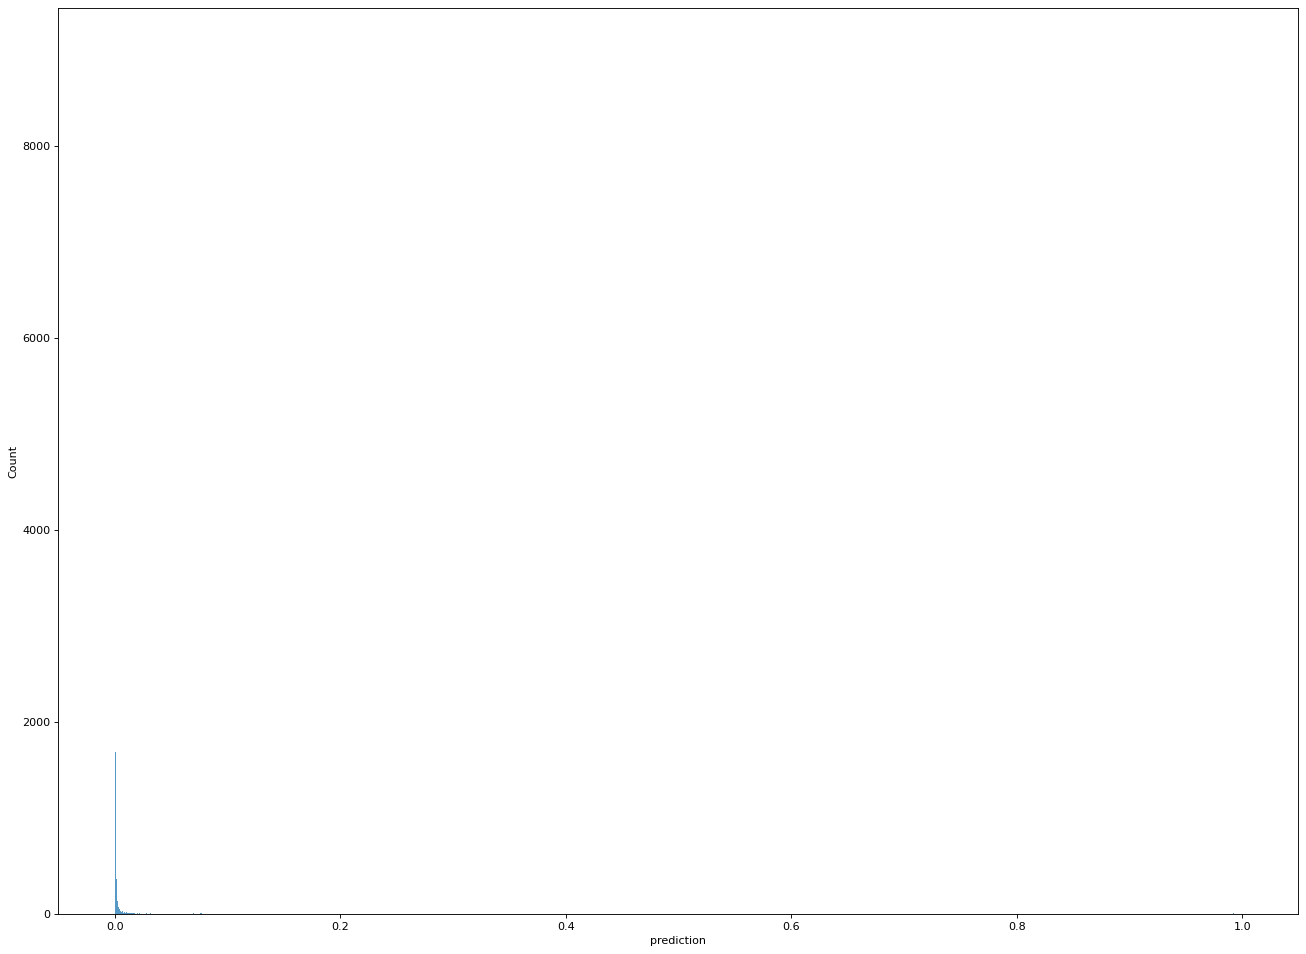

In [ ]:
import seaborn as sns
from matplotlib.pyplot import figure

figure(figsize=(20, 15), dpi=80)

sns.histplot(temp, fill=True)
# sns.histplot(pos, fill=True)

In [ ]:
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.preprocessing import LabelEncoder

from catboost import CatBoostClassifier

In [ ]:
########################### Model
SEED = 42
LOCAL_TEST = False

def make_predictions(tr_df, tt_df, features_columns, target, cat_params, NFOLDS=4, kfold_mode='grouped'):
    
    X,y = tr_df[features_columns], tr_df[target]    
    P,P_y = tt_df[features_columns], tt_df[target]  
    split_groups = tr_df['DT_M']

    tt_df = tt_df[['TransactionID',target]] 
    tr_df = tr_df[['TransactionID',target]] 
    
    predictions = np.zeros(len(tt_df))
    oof = np.zeros(len(tr_df))

    if kfold_mode=='grouped':
        folds = GroupKFold(n_splits=NFOLDS)
        folds_split = folds.split(X, y, groups=split_groups)
    else:
        folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)
        folds_split = folds.split(X, y)

    for fold_, (trn_idx, val_idx) in enumerate(folds_split):        
        print('Fold:',fold_)
        
        estimator = CatBoostClassifier(**cat_params)        
        estimator.fit(
            X.iloc[trn_idx,:],y[trn_idx],
            eval_set=(X.iloc[val_idx,:], y[val_idx]),
            cat_features=categorical_features,
            use_best_model=True,
            verbose=True)
        
        pp_p = estimator.predict_proba(P)[:,1]
        predictions += pp_p/NFOLDS
        
        oof_preds = estimator.predict_proba(X.iloc[val_idx,:])[:,1]
        oof[val_idx] = (oof_preds - oof_preds.min())/(oof_preds.max() - oof_preds.min())
        
        del estimator
        gc.collect()
        
    tt_df['prediction'] = predictions
    print('OOF AUC:', metrics.roc_auc_score(y, oof))
    if LOCAL_TEST:
        print('Holdout AUC:', metrics.roc_auc_score(tt_df[TARGET], tt_df['prediction']))
    
    return tt_df
## -------------------

In [ ]:
########################### Vars
TARGET = 'isFraud'
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

In [ ]:
########################### Model params
cat_params = {
                'n_estimators':5000,
                # 'learning_rate': 0.07,
                'eval_metric':'AUC',
                'loss_function':'Logloss',
                'random_seed':SEED,
                # 'metric_period':500,
                # 'od_wait':500,
                # 'task_type':'GPU',
                # 'depth': 8,
                #'colsample_bylevel':0.7,
                } 

In [ ]:
########################### DATA LOAD
#################################################################################
df = pd.read_pickle('')
remove_features = pd.read_pickle('../input/ieee-fe-with-some-eda/remove_features.pkl')
remove_features = list(remove_features['features_to_remove'].values)
print('Done')

In [ ]:
########################### Encode NaN goups
nans_groups = {}
temp_df = df.isna()
nans_df = temp_df.copy()

for col in list(nans_df):
    cur_group = nans_df[col].sum()
    if cur_group>0:
        try:
            nans_groups[cur_group].append(col)
        except:
            nans_groups[cur_group]=[col]

add_category = []
for col in nans_groups:
    if len(nans_groups[col])>1:
        df['nan_group_'+str(col)] = np.where(temp_df[nans_groups[col]].sum(axis=1)>0,1,0).astype(np.int8)
        add_category.append('nan_group_'+str(col))
        
del temp_df, nans_df, nans_groups

In [ ]:
########################### Copy original Categorical features
categorical_features = ['ProductCD','M4',
                        'card1','card2','card3','card4','card5','card6',
                        'addr1','addr2','dist1','dist2',
                        'P_emaildomain','R_emaildomain',
                       ]

o_trans = pd.concat([pd.read_pickle('../input/ieee-data-minification/train_transaction.pkl'),
                     pd.read_pickle('../input/ieee-data-minification/test_transaction.pkl')])

o_ident = pd.concat([pd.read_pickle('../input/ieee-data-minification/train_identity.pkl'),
                     pd.read_pickle('../input/ieee-data-minification/test_identity.pkl')])

